In [ ]:
import asyncio
import aiohttp
import time
import numpy as np
import matplotlib.pyplot as plt
from collections import Counter

import pandas as pd
import nest_asyncio
import threading

# Function to print the number of active threads
def print_active_threads():
    print(f"Number of active threads: {threading.active_count()}")



nest_asyncio.apply()

# Parameters
LAMBDA = 800  # Arrival rate (requests per second)
TOTAL_REQUESTS = 20000  # Total number of requests to simulate
# URL = "http://traffic.test.local/single"
URL = "http://traffic.test.local/load-balanced"

# Generate inter-arrival times (exponential distribution)
inter_arrival_times = np.random.exponential(1 / LAMBDA, TOTAL_REQUESTS)
arrival_times = np.cumsum(inter_arrival_times)  # Cumulative arrival times

# Lists to store data
timestamps = []
time_at_requests = []
response_times = []
status_codes = []
user_counts = []  # To track users in the system over time (client side)

starting_time = time.time()

active_requests = 0  # Current number of active requests
lock = asyncio.Lock()  # To manage concurrent access to shared variables


async def send_request(session, idx, start_time):
    global active_requests
    # Wait until the scheduled arrival time
    await asyncio.sleep(max(0, arrival_times[idx] - (time.time() - start_time)))
    request_time = time.time() - start_time
    time_at_request = time.time()

    # Increment active requests
    async with lock:
        active_requests += 1
        user_counts.append((request_time, active_requests))

    try:
        async with session.get(URL) as response:
            status = response.status
            elapsed_time = time.time() - start_time - request_time
    except Exception:
        status = None
        elapsed_time = time.time() - start_time - request_time

    # Decrement active requests
    async with lock:
        active_requests -= 1
        user_counts.append((time.time() - start_time, active_requests))

    # Record data
    timestamps.append(request_time)
    response_times.append(elapsed_time)
    status_codes.append(status)
    time_at_requests.append(time_at_request)


async def main():
    # Example usage
    print_active_threads()
    start_time = time.time()
    async with aiohttp.ClientSession() as session:
        tasks = [
            send_request(session, idx, start_time) for idx in range(TOTAL_REQUESTS)
        ]
        await asyncio.gather(*tasks)


# Run the simulation
if __name__ == "__main__":
    asyncio.run(main())

# Calculate loss probability
total_requests = len(status_codes)
dropped_requests = status_codes.count(503)
loss_probability = dropped_requests / total_requests if total_requests > 0 else 0



Number of active threads: 9


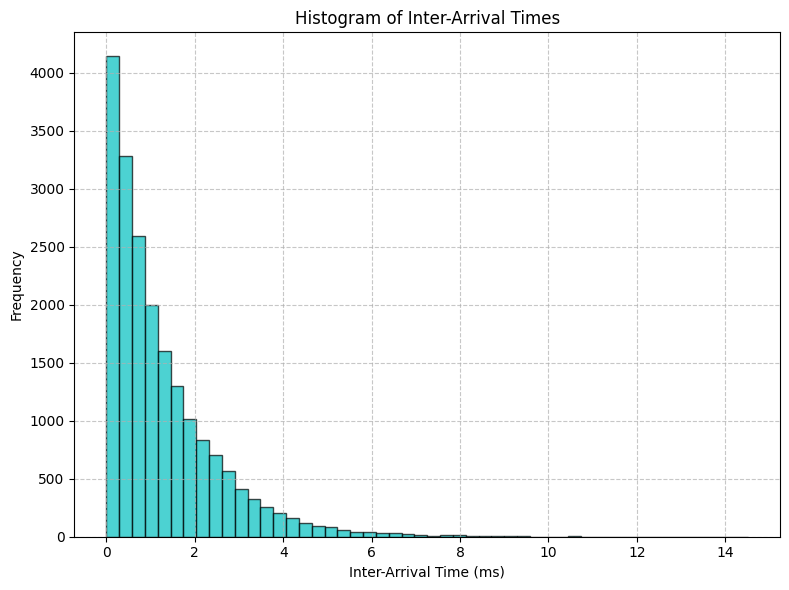

In [305]:
# Convert inter-arrival times to milliseconds
inter_arrival_times_ms = inter_arrival_times * 1000  # Convert seconds to milliseconds

# Plot histogram of inter-arrival times
plt.figure(figsize=(8, 6))
plt.hist(inter_arrival_times_ms, bins=50, color='c', edgecolor='k', alpha=0.7)
plt.title('Histogram of Inter-Arrival Times')
plt.xlabel('Inter-Arrival Time (ms)')
plt.ylabel('Frequency')
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()
plt.show()


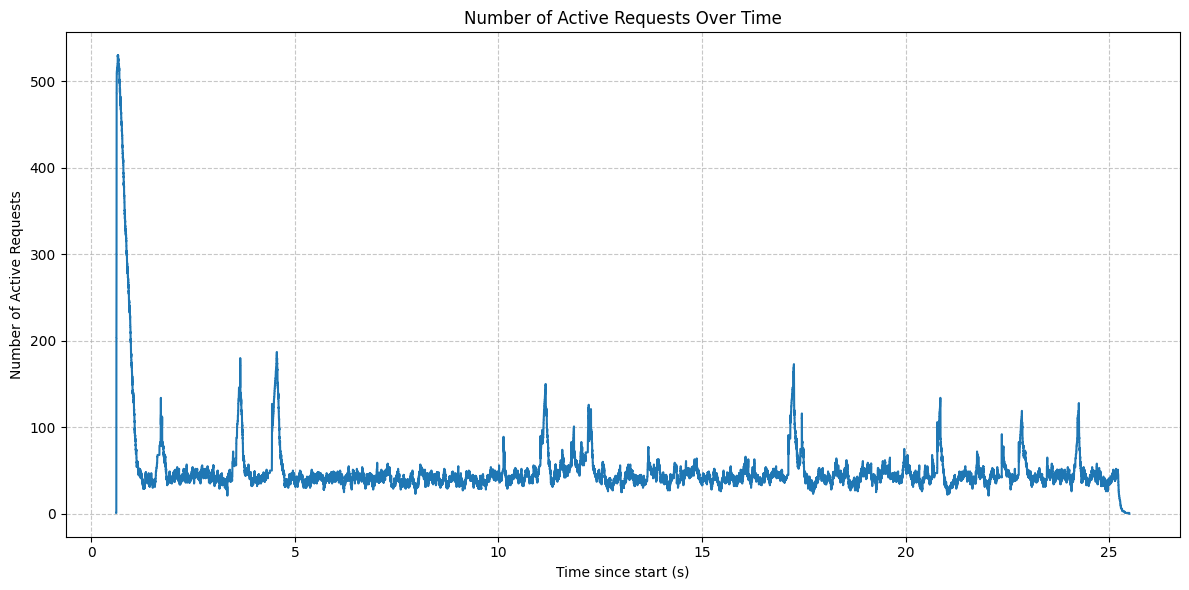

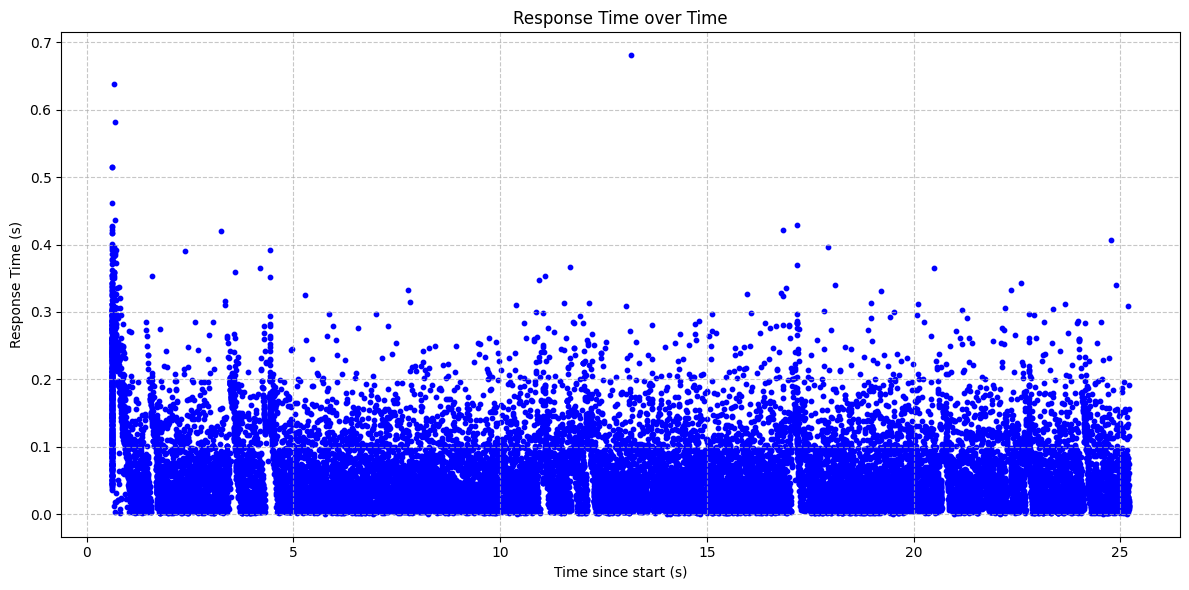

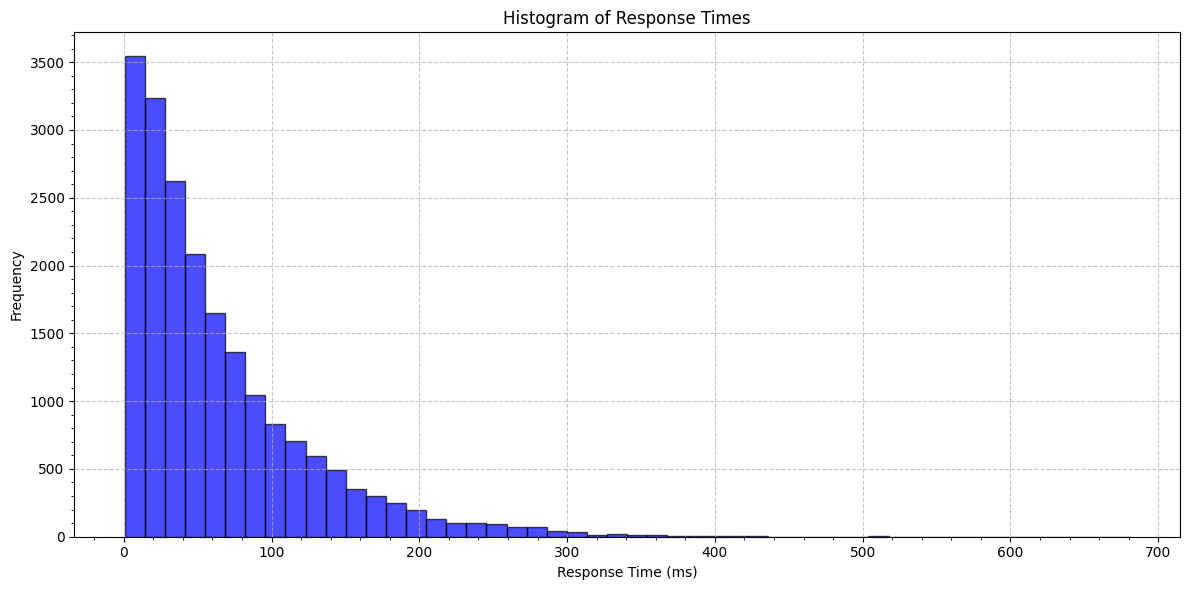

Total Requests: 20000
Mean Response Time: 64.065 ms


In [306]:
# Extract data for plotting users over time
user_times, user_numbers = zip(*sorted(user_counts))

# Plot number of active requests over time
plt.figure(figsize=(12, 6))
plt.step(user_times, user_numbers, where="post")
plt.title("Number of Active Requests Over Time")
plt.xlabel("Time since start (s)")
plt.ylabel("Number of Active Requests")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()



# Plot response times over time for status code 200
plt.figure(figsize=(12, 6))
plt.scatter(timestamps, response_times, color="blue", s=10)
plt.title("Response Time over Time")
plt.xlabel("Time since start (s)")
plt.ylabel("Response Time (s)")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()


# Plot histogram of response times for status code 200
plt.figure(figsize=(12, 6))
# times 1000 to convert seconds to milliseconds
response_times_ms = [time * 1000 for time in response_times if time is not None]
plt.hist(response_times_ms, bins=50, color='blue', edgecolor='k', alpha=0.7)
plt.title("Histogram of Response Times")
plt.xlabel("Response Time (ms)")
plt.ylabel("Frequency")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.minorticks_on()
plt.show()

# Create a DataFrame with the timestamps when requests were sent
df_packets = pd.DataFrame({"timestamp": timestamps})
df_packets.sort_values("timestamp", inplace=True)

# Calculate cumulative packets sent
df_packets["packets_sent"] = range(1, len(df_packets) + 1)
    
print(f"Total Requests: {total_requests}")
if response_times:
    print(f"Mean Response Time: {np.mean(response_times)*1000:.3f} ms")


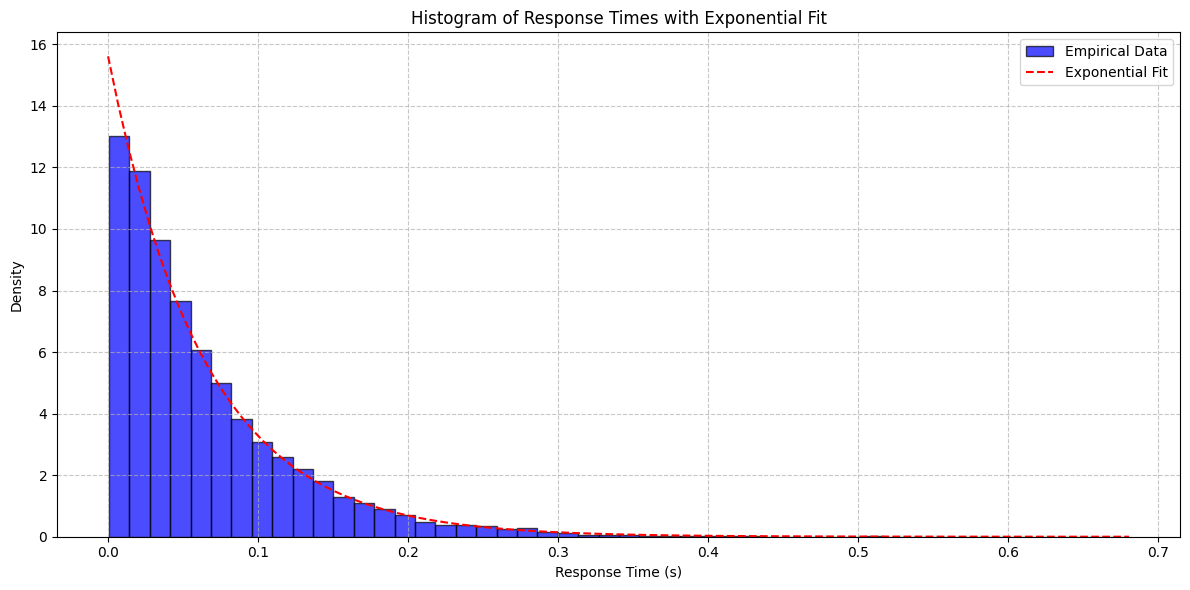

Weibull K-S Test: D=0.0299, p-value=0.0000


In [307]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import expon, kstest

# Assuming successful_response_times contains the response times for status code 200
# If not already defined, filter the response times:

successful_response_times = [response_times[i] for i in range(len(response_times)) if status_codes[i] == 200]

# Convert to numpy array for convenience
response_times_array = np.array(successful_response_times)

# Plot histogram of response times
plt.figure(figsize=(12, 6))
counts, bins, patches = plt.hist(response_times_array, bins=50, density=True, color='blue', alpha=0.7, edgecolor='black', label='Empirical Data')

# Fit an exponential distribution
loc, scale = expon.fit(response_times_array, floc=0)  # Force location to 0

x = np.linspace(0, response_times_array.max(), 100)
pdf_fitted = expon.pdf(x, loc, scale)

# Overlay the exponential PDF
# plt.plot(x, pdf_fitted, 'r--', label=f'Exponential Fit (λ={1/scale:.2f})')
plt.plot(x, pdf_fitted, 'r--', label=f'Exponential Fit')

plt.title("Histogram of Response Times with Exponential Fit")
plt.xlabel("Response Time (s)")
plt.ylabel("Density")
plt.legend()
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

# Perform Kolmogorov-Smirnov test
D, p_value = kstest(response_times_array, 'expon', args=(loc, scale))
print(f"Weibull K-S Test: D={D:.4f}, p-value={p_value:.4f}")


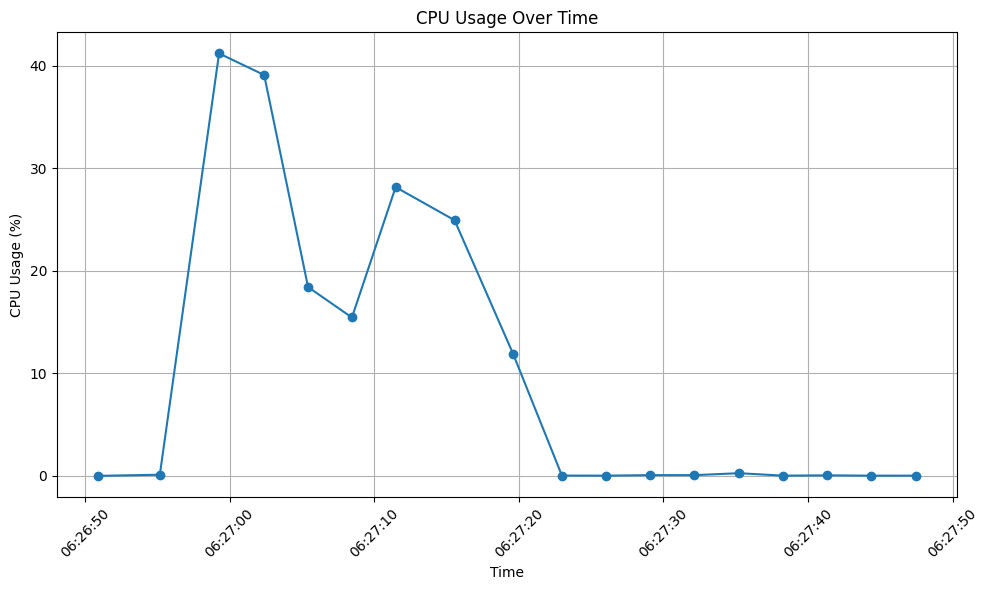

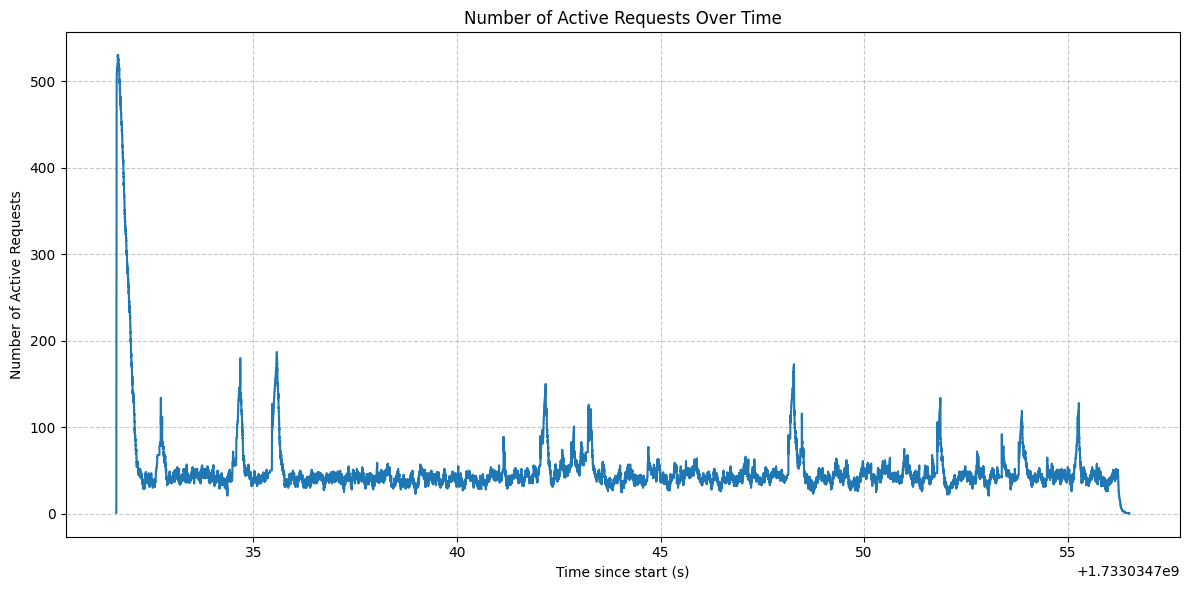

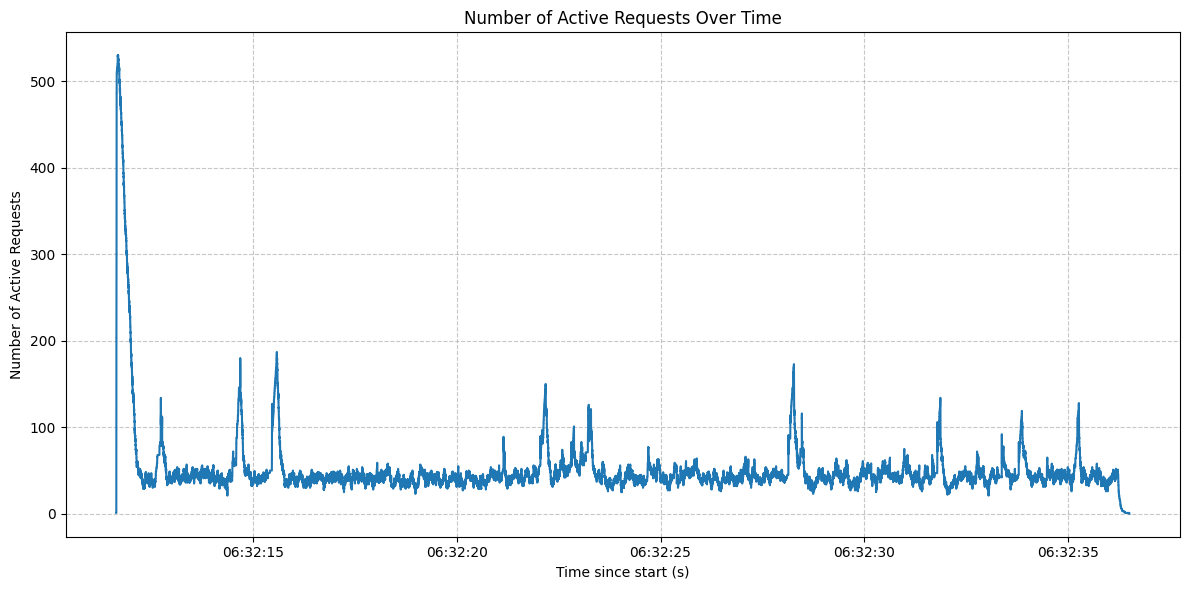

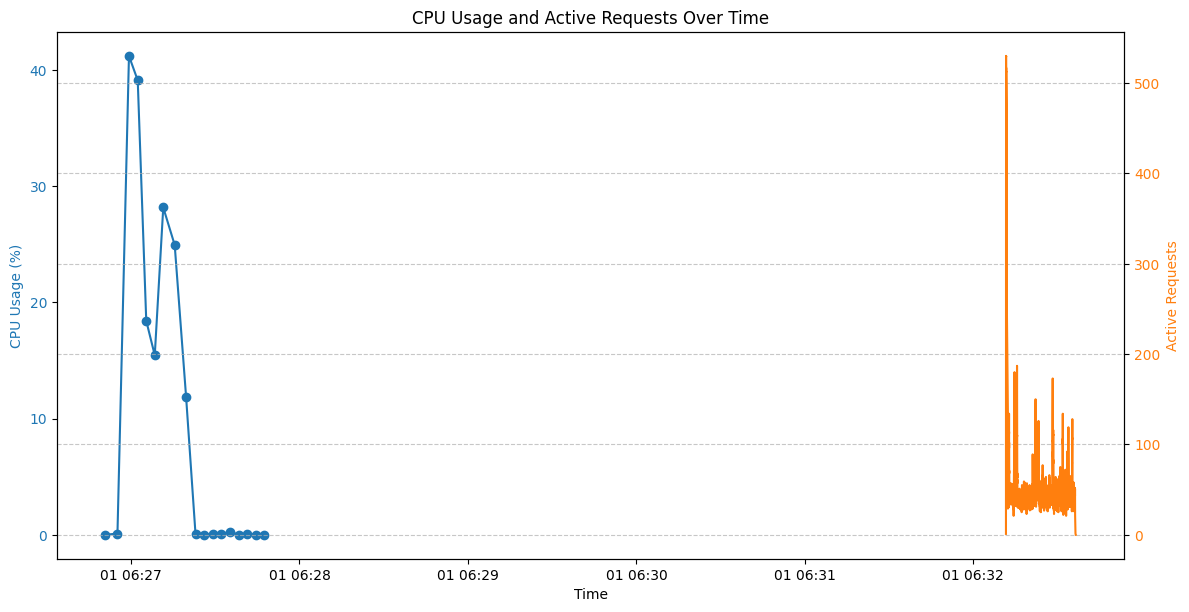

In [308]:
import pandas as pd
import matplotlib.pyplot as plt
import time

# Read the CSV file
df = pd.read_csv('docker_stats.csv',usecols=[0,1] ,names=['timestamp', 'cpu_usage'], skiprows=1)

# Convert the timestamp column to datetime
df['timestamp'] = pd.to_datetime(df['timestamp']).dt.tz_localize('Etc/GMT-7')

df['timestamp'] = df['timestamp'].dt.tz_convert('UTC')

# Remove the '%' sign and convert the cpu_usage column to numeric
df['cpu_usage'] = df['cpu_usage'].str.replace('%', '').astype(float)

# Plot CPU usage over time
plt.figure(figsize=(10, 6))
plt.plot(df['timestamp'], df['cpu_usage'], marker='o', linestyle='-')
plt.xlabel('Time')
plt.ylabel('CPU Usage (%)')
plt.title('CPU Usage Over Time')
plt.grid(True)
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

# Create a new DataFrame for user_times and user_numbers
user_times, user_numbers = zip(*sorted(user_counts))

user_times = np.array(user_times) + starting_time

# Plot number of active requests over time
plt.figure(figsize=(12, 6))
plt.step(user_times, user_numbers, where="post")
plt.title("Number of Active Requests Over Time")
plt.xlabel("Time since start (s)")
plt.ylabel("Number of Active Requests")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

user_df = pd.DataFrame({'req_time': pd.to_datetime(user_times, unit='s'), 'user_numbers': user_numbers})
user_df['req_time'] = user_df['req_time'].dt.tz_localize('UTC')

# Plot number of active requests over time
plt.figure(figsize=(12, 6))
plt.step(user_df['req_time'], user_df['user_numbers'], where="post")
plt.title("Number of Active Requests Over Time")
plt.xlabel("Time since start (s)")
plt.ylabel("Number of Active Requests")
plt.grid(True, linestyle="--", alpha=0.7)
plt.tight_layout()
plt.show()

user_df['req_time'] = user_df['req_time'].dt.round('ms')
df['timestamp'] = df['timestamp'].dt.round('ms')

# Plot CPU usage and active requests over time
fig, ax1 = plt.subplots(figsize=(12, 6))

ax1.set_xlabel('Time')
ax1.set_ylabel('CPU Usage (%)', color='tab:blue')
ax1.plot(df['timestamp'], df['cpu_usage'], color='tab:blue', marker='o', linestyle='-', label='CPU Usage')
ax1.tick_params(axis='y', labelcolor='tab:blue')

ax2 = ax1.twinx()
ax2.set_ylabel('Active Requests', color='tab:orange')
# ax2.step(user_df['req_time'], user_df['user_numbers'], where="post", color='tab:orange', linestyle="--", label='Active Requests')
ax2.plot(user_df['req_time'], user_df['user_numbers'], color='tab:orange', linestyle='-', label='Active Requests')
ax2.tick_params(axis='y', labelcolor='tab:orange')

fig.tight_layout()
plt.title('CPU Usage and Active Requests Over Time')
plt.xticks(rotation=45)
plt.grid(True, linestyle="--", alpha=0.7)
plt.show()